# EVALUATING AUTOENCODERS

The evaluation encompasses
* **Function recovery**. Can the autoencoder accurately recover time courses from reaction networks.
* **Insightful interpretation**. Does the autoencoder produce a low dimension representation that provides useful insights.

The initial focus is on function recovery. To gain insight into the effectiveness of autoencoders for this task, we start by considering synthetic time courses to investigate the ability of autoencoderes to recover functions similar to those used in rate laws of biological systems.

# Preliminaries

In [1]:
from autoencodersb import constants as cn
from autoencodersb.data_generator import DataGenerator
from autoencodersb.dataset_csv import DatasetCSV
from autoencodersb.polynomial_collection import PolynomialCollection
from autoencodersb.model_runner_pca import ModelRunnerPCA
from autoencodersb.model_runner_nn import ModelRunnerNN
from autoencodersb.autoencoder import Autoencoder
from autoencodersb.sequence import Sequence
from autoencodersb.model_runner_pca import ModelRunnerPCA
from autoencodersb.autoencoder import Autoencoder  # type: ignore
from autoencodersb.autoencoder_umap import AutoencoderUMAP # type: ignore
from autoencodersb.model_runner_umap import ModelRunnerUMAP # type: ignore

import numpy as np
from torch.utils.data import DataLoader
import pandas as pd
import tellurium as te
import torch

# Models

## Wolf

In [2]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml")
WOLF_ARR = rr.simulate(0, 10, 1000)
columns = [c[1:-1] if c != 'time' else c for c in WOLF_ARR.colnames]
WOLF_DF = pd.DataFrame(WOLF_ARR, columns=columns)

## Cell Cycle

In [3]:
url = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL2004140001/3/Garde2020.xml"
rr = te.loadSBMLModel(url)
arr = rr.simulate(0, 10, 1000)
columns = [c[1:-1] if c != 'time' else c for c in arr.colnames]
CELL_CYCLE_DF = pd.DataFrame(arr, columns=columns)
del CELL_CYCLE_DF["B"]
CELL_CYCLE_ARR = CELL_CYCLE_DF.values

# Helpers

## plotModel

In [4]:
def plotModel(url, title="", eliminate_idxs=None):
    # Plots the model on BioModels and returns its data
    rr = te.loadSBMLModel(url)
    arr = rr.simulate(0, 10, 1000)
    columns = [c[1:-1] if c != 'time' else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    if eliminate_idxs is not None:
        idxs = set(range(arr.shape[1])) - set(eliminate_idxs)
        idx_arr = np.array(list(idxs))
        arr = arr[:, idx_arr]
    plt.plot(arr[:, 0], arr[:, 1:])
    plt.title(title)
    return df

## plotUMAP

In [5]:
def plotUMAP(arr, n_component: int = 2, start_idx: int = 1, title=""):
    # Ignores the first
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=n_component, random_state=42)
    embedding = reducer.fit_transform(arr[:, start_idx:])
    # Plot the results
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title(title)
    plt.show()
    return embedding

## fitSimulation

In [6]:
def fitSimulation(simulation_arr: np.ndarray, num_epoch: int = 100, num_output_feature: int = 2) -> ModelRunnerUMAP:
    # Fits a NN model to the output of a simulation
    columns = None
    if isinstance(simulation_arr, pd.DataFrame):
        columns = simulation_arr.columns
        simulation_arr = simulation_arr.values
    if hasattr(simulation_arr, 'colnames'):
        columns = [c[1:-1] if c != 'time' else c for c in simulation_arr.colnames]
    else:
        if columns is None:
            columns = [str(n) for n in range(simulation_arr.shape[1])]
            columns[0] = 'time'
    num_input_feature = simulation_arr.shape[1] - 1  # ignore time
    #
    autoencoder_umap = AutoencoderUMAP(layer_dimensions=[num_input_feature, 10*num_input_feature,
            10*num_output_feature, num_output_feature])  # Example model
    runner = ModelRunnerUMAP(model=autoencoder_umap, num_epoch=num_epoch)
    df = pd.DataFrame(simulation_arr[:, 1:], columns=columns[1:])
    data_dl = DataLoader(DatasetCSV(csv_input=df, target_column=None),
                    shuffle=False, batch_size=32)
    _ = runner.fit(data_dl)
    return runner

# Tests
result = fitSimulation(WOLF_ARR, num_epoch=10)
assert(isinstance(result, ModelRunnerUMAP))
print("OK!")
    

epochs (loss (std)=1.5480): 100%|███████████████| 10/10 [00:01<00:00,  9.88it/s]

OK!


##  plotSimulationFit

In [7]:
def plotSimulationFit(simulation_df: pd.DataFrame, num_epoch: int = 100, num_output_feature: int = 2,
        offset:int = 0, is_plot: bool = True) -> ModelRunnerUMAP:
    new_simulation_df = simulation_df.copy()
    new_simulation_df = simulation_df.loc[offset:, :]
    runner = fitSimulation(new_simulation_df, num_epoch=num_epoch, num_output_feature=num_output_feature)
    feature_tnsr = torch.Tensor(new_simulation_df.values[:, 1:])
    prediction_tnsr = runner.predict(feature_tnsr)
    prediction_arr = prediction_tnsr.detach().to(cn.CPU).numpy()
    if is_plot:
        del new_simulation_df["time"]
        plotUMAP(new_simulation_df.values)
        plt.plot(simulation_df.loc[offset:, "time"], prediction_arr)
        plt.xlabel("time")
    return runner

# Tests
runner = plotSimulationFit(CELL_CYCLE_DF, num_epoch=10, offset=20, is_plot=False)
assert(isinstance(runner, ModelRunnerUMAP))
print("OK!")

epochs (loss (std)=0.6803): 100%|███████████████| 10/10 [00:00<00:00, 11.01it/s]


OK!


# Evaluation Data

## Synthetic data

Below we describe the data used to evaluate autoencoders.

The emphasis is on time series similar to those encountered in biological models. Our approach is to consider the functional form of common rate laws. These typically consist of a single term that is one of the following:

* A constant times the concentration of a floating species. This is a first order polynomal.
    * $A \rightarrow B;~ kA$.
* A constant times a the product of concentrations of two floatin species. This is a second order polynomial.
    * $A B \rightarrow C;~ k A B$
* An ratio of polynomials for Michaelis-Menten and Hill Equations
    * $A \rightarrow B; ~ \frac{v A^n}{(k + A^n)}$

We consider tree different time series for the floating species in a rate law
* Linear: $A = kt$, where $k$ is a fixed constant
* Exponential: $A = e^{-r t}$
* Exponential integeral: $A = 1 - e^{-r t}/r$

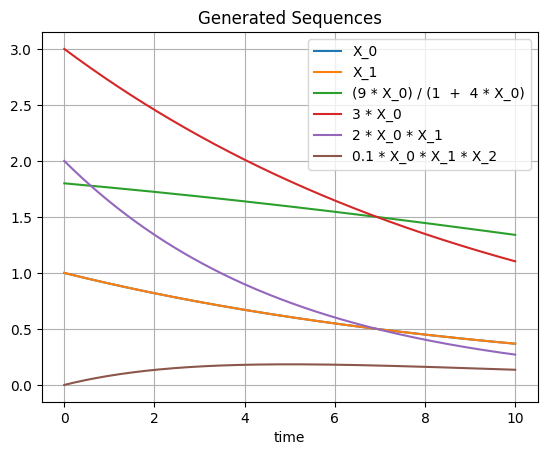

In [8]:
polynomial_collection = PolynomialCollection.make(
        is_mm_term=True,
        is_first_order_term=3,
        is_second_order_term=2,
        is_third_order_term=0.1)
num_point = 2000
end_time = 10
GENERATOR_TRAIN = DataGenerator(polynomial_collection=polynomial_collection,
        num_sample=num_point)
SEQUENCES = [Sequence(num_point=num_point, end_time=end_time, rate=0.1, seq_type=cn.SEQ_EXPONENTIAL),
             Sequence(num_point=num_point, end_time=end_time, rate=0.1, seq_type=cn.SEQ_EXPONENTIAL),
             Sequence(num_point=num_point, end_time=end_time, seq_type=cn.SEQ_LINEAR)]
GENERATOR_TRAIN.specifySequences(sequences=SEQUENCES)
GENERATOR_TRAIN.generate()
GENERATOR_TRAIN.plotGeneratedData(x_column="X_2")
TRAIN_DF = GENERATOR_TRAIN.data_df
TRAIN_DL = GENERATOR_TRAIN.data_dl

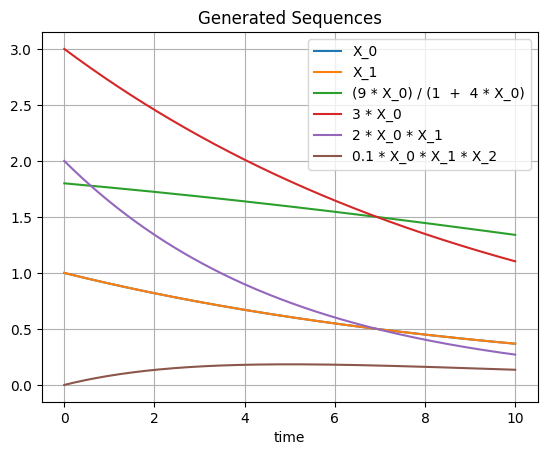

In [9]:
GENERATOR_TEST = DataGenerator(polynomial_collection=polynomial_collection,
        num_sample=num_point)
GENERATOR_TEST.specifySequences(sequences=SEQUENCES)
GENERATOR_TEST.generate()
GENERATOR_TRAIN.plotGeneratedData(x_column="X_2")
TEST_DF = GENERATOR_TEST.data_df
TEST_DL = GENERATOR_TEST.data_dl

# PCA

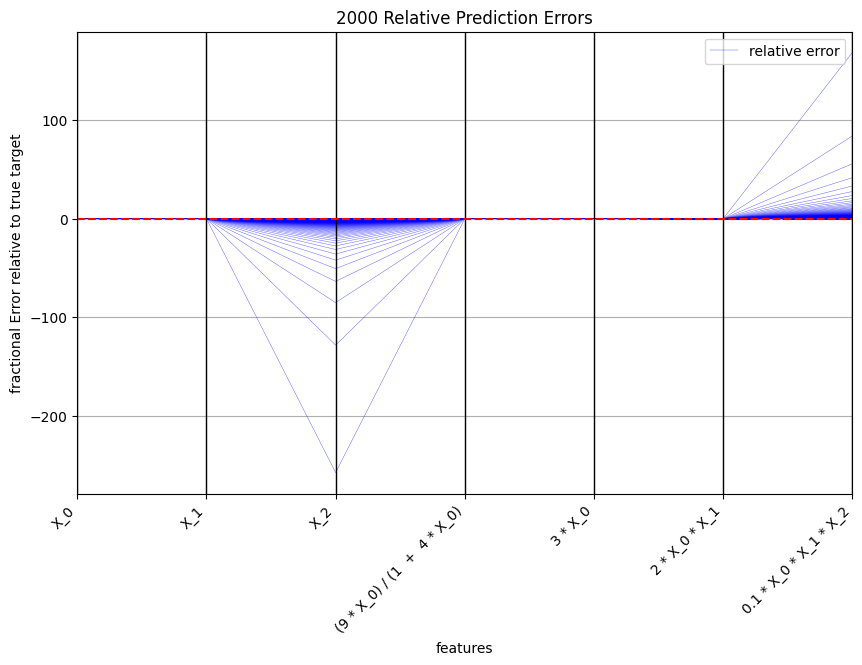

In [10]:
pca_rnr = ModelRunnerPCA(n_components=1)
runner_result = pca_rnr.fit(GENERATOR_TRAIN.data_dl)
pca_rnr.plotEvaluate(GENERATOR_TRAIN.data_dl)

# Autoencoder

In [11]:
NUM_INPUT_FEATURE = 7
NUM_OUTPUT_FEATURE = 1
NUM_EPOCH = 10000

MODEL = Autoencoder(layer_dimensions=[NUM_INPUT_FEATURE, 10*NUM_INPUT_FEATURE,
        10*NUM_OUTPUT_FEATURE, NUM_OUTPUT_FEATURE])

if False:
    runner = ModelRunnerNN(model=MODEL, num_epoch=NUM_EPOCH,
                    learning_rate=1e-5, is_normalized=True,
                    max_fractional_error=0.1)
    runner_result_fit = runner.fit(TRAIN_DL)
    runner.plotEvaluate(TEST_DL)

# UMAP

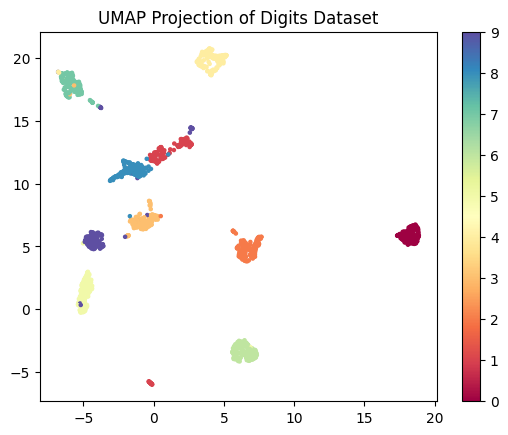

In [12]:
import umap
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load sample data
digits = load_digits()
data = digits.data

# Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Projection of Digits Dataset')
plt.show()


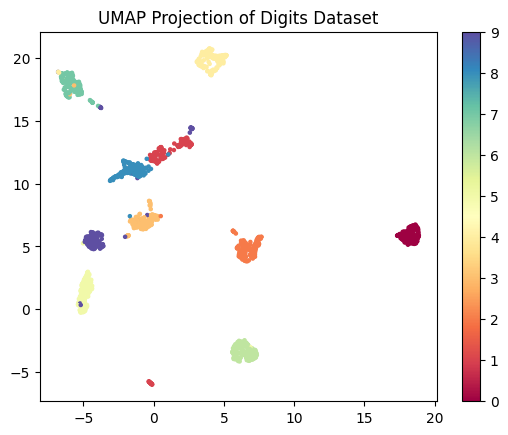

In [13]:
import umap
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load sample data
digits = load_digits()
data = digits.data

# Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Projection of Digits Dataset')
plt.show()

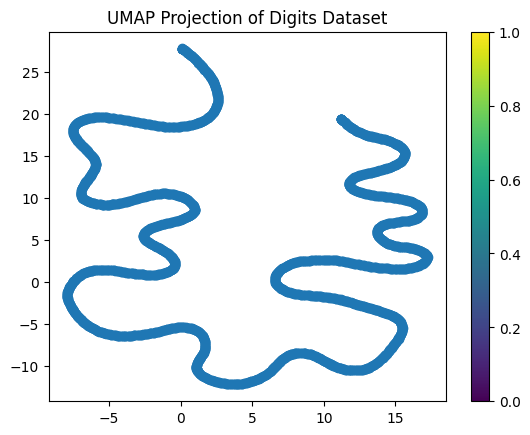

In [14]:
# UMAP for generated data
data = TRAIN_DF.values

# Initialize and fit UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.colorbar()
plt.title('UMAP Projection of Digits Dataset')
plt.show()

In [15]:
reconstructed = reducer.inverse_transform(embedding)
np.shape(reconstructed)

(2000, 7)

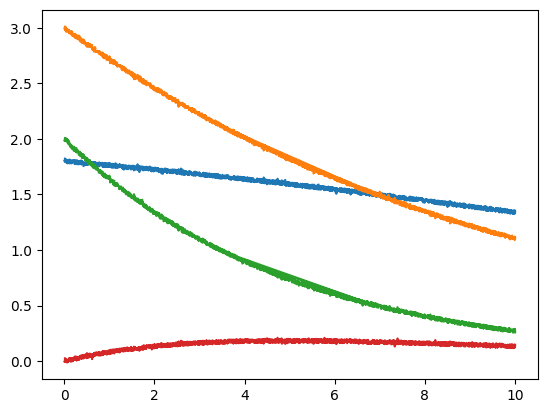

In [16]:
plt.plot(reconstructed[:, 2], reconstructed[:, 3:])

## Wolf Model

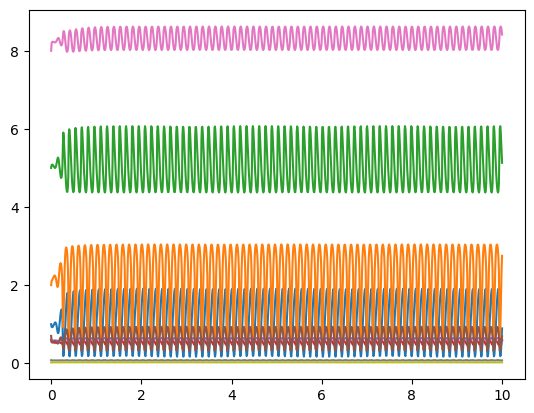

In [17]:
plt.plot(WOLF_ARR[:, 0], WOLF_ARR[:, 1:])

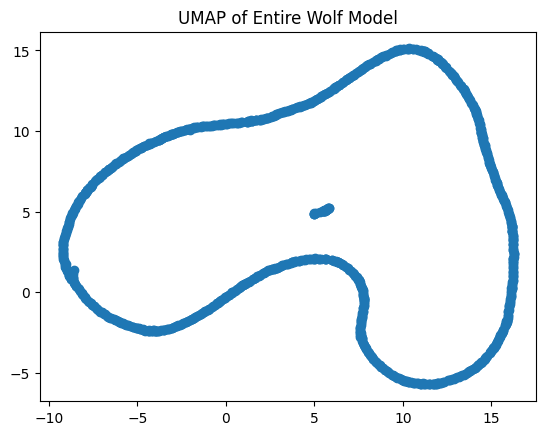

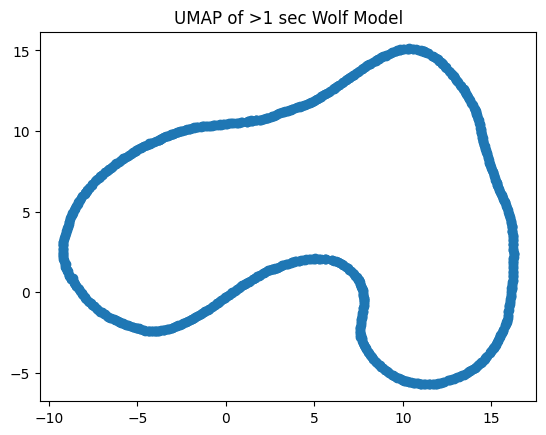

In [18]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(WOLF_ARR[:, 1:])

# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('UMAP of Entire Wolf Model')
plt.show()

# Plot the results
idx_arr = np.array(range(100, 1000))
plt.scatter(embedding[idx_arr, 0], embedding[idx_arr, 1])
plt.title('UMAP of >1 sec Wolf Model')
plt.show()

In [19]:
num_input_feature = WOLF_ARR.shape[1] - 1  # ignore time
num_output_feature = 2
num_epoch = 10000

autoencoder_umap = AutoencoderUMAP(layer_dimensions=[num_input_feature, 10*num_input_feature,
        10*num_output_feature, num_output_feature])  # Example model
runner = ModelRunnerUMAP(model=autoencoder_umap, num_epoch=num_epoch)
df = WOLF_DF.copy()
del df["time"]
data_dl = DataLoader(DatasetCSV(csv_input=df, target_column=None),
                shuffle=False, batch_size=32)
_ = runner.fit(data_dl)

epochs (loss (std)=0.3318): 100%|█████████| 10000/10000 [14:58<00:00, 11.13it/s]


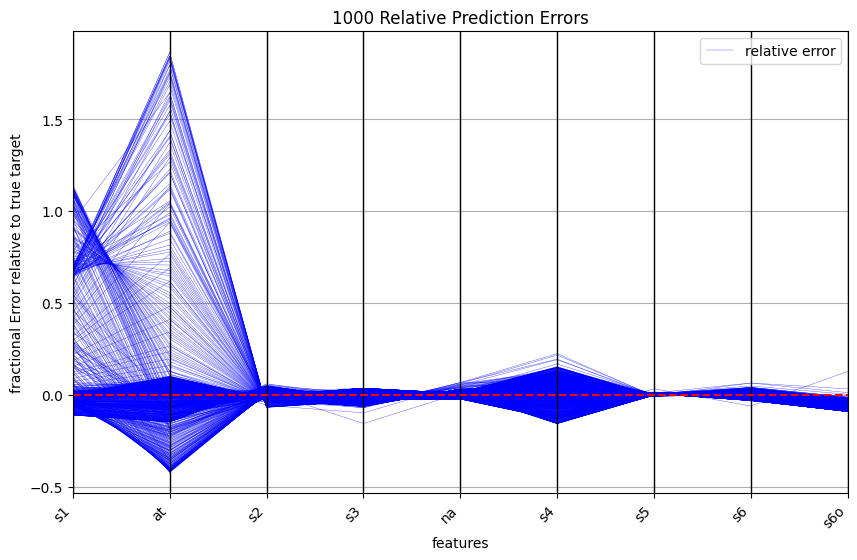

In [20]:
runner.plotEvaluate(data_dl)

In [21]:
runner.serialize("wolf.pkl")

In [22]:
new_runner = ModelRunnerUMAP.deserialize(path="wolf.pkl")

Evaluate the accuracy of the embedding

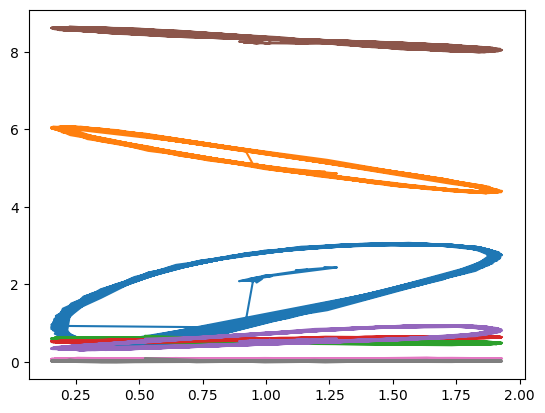

In [23]:
reconstructed = reducer.inverse_transform(embedding)
plt.plot(reconstructed[:, 0], reconstructed[:, 1:])

## Cell Cycle

In [27]:
CELL_CYCLE_DF.head()

,time,Gp,Gi,A
0,0.00000,1.000000,1.000000,1.000000
1,0.01001,1.030722,0.997335,0.983288
2,0.02002,1.063310,0.995355,0.967179
3,0.03003,1.097848,0.994085,0.951666
4,0.04004,1.134424,0.993548,0.936742


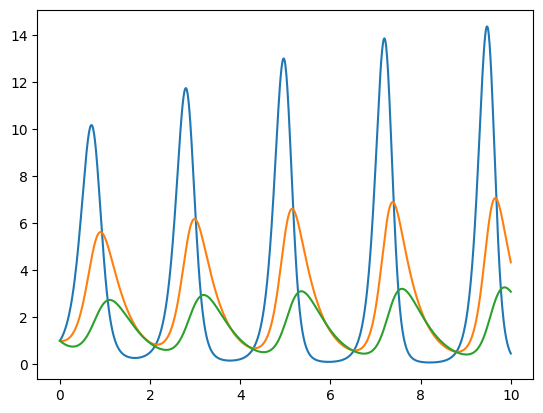

In [31]:
plt.plot(CELL_CYCLE_DF["time"], CELL_CYCLE_DF[["Gp", "Gi", "A"]])

epochs (loss (std)=0.1307): 100%|███████████| 2000/2000 [02:54<00:00, 11.43it/s]


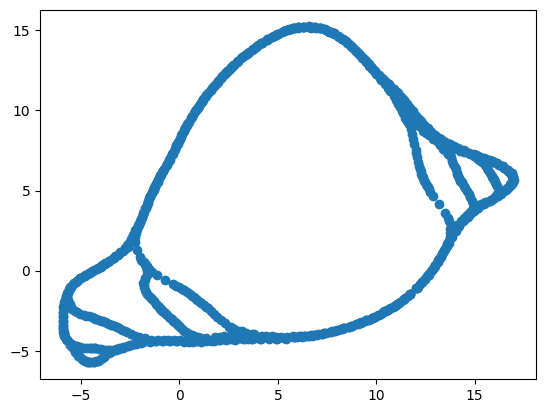

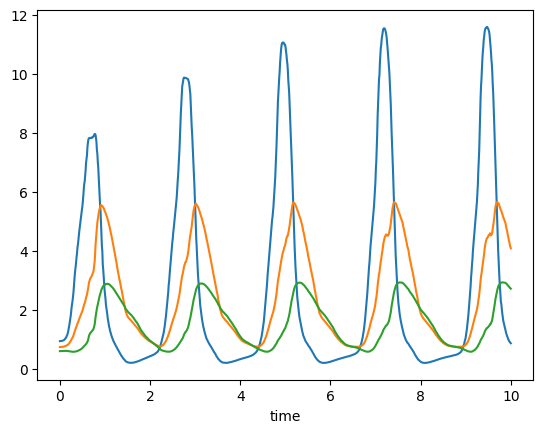

In [24]:
plotSimulationFit(CELL_CYCLE_DF,  num_epoch=10000)

epochs (loss (std)=0.1306): 100%|███████████| 2000/2000 [02:49<00:00, 11.83it/s]


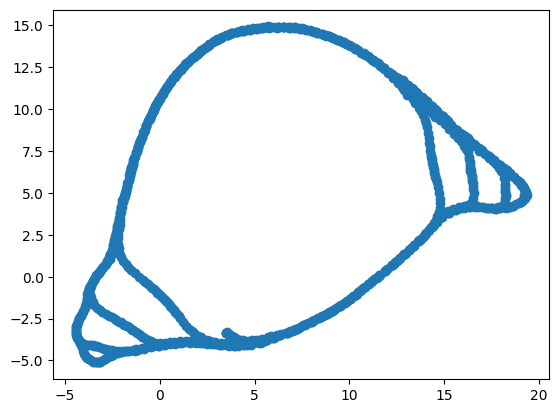

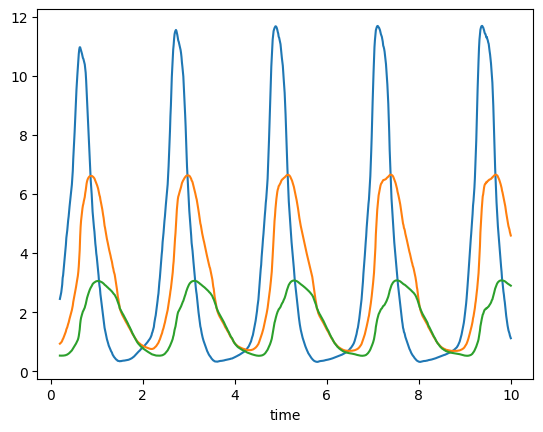

In [25]:
_ = plotSimulationFit(CELL_CYCLE_DF, num_epoch=10000, offset=20)

**Notes**
1. Different phases show up as deviations from the single line.
2. 

# TO DO

1. Test Hill ratio terms
2. Select synthetic data for evaluations
3. Evaluate w.r.t. PCA